In [1]:
import pandas as pd
import numpy as np
import scipy.special
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Legend, CDSView, BooleanFilter
from bokeh.models import HoverTool, LegendItem
from bokeh.models import CustomJS, Div, Button
from bokeh import events
from bokeh.layouts import column, row
from bokeh.palettes import Spectral5,Viridis256,Category20
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import gridplot
from bokeh.transform import linear_cmap
output_notebook()

Loading BokehJS ...

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
excel_source = pd.read_excel("Demand.xlsx",sheet_name=None)
units_pallet = excel_source.get("Units per Pallet")
breakout = excel_source.get("Breakout")
rates_umbra = excel_source.get("Umbra")
rates_thiele = excel_source.get("Thiele")
rates_parsons = excel_source.get("Parsons")
rates_ptech = excel_source.get("Premier Tech")
demand = excel_source.get("Demand")

In [4]:
bk_umbra = ColumnDataSource(rates_umbra)
bk_thiele = ColumnDataSource(rates_thiele)
bk_parsons = ColumnDataSource(rates_parsons)
bk_ptech = ColumnDataSource(rates_ptech)

In [5]:
units_pallet.set_index('Item Number', inplace = True)
breakout.set_index('Item Number', inplace = True)
rates_umbra.set_index('item', inplace = True)
rates_ptech.set_index('UPC', inplace = True)
rates_thiele.set_index('UPC', inplace = True)
rates_parsons.set_index('UPC', inplace = True)
demand.set_index('item number', inplace = True)

In [6]:
groups_breakout = breakout.groupby(breakout.index)
mf_groups_breakout = breakout.groupby('Master Formula Number')

In [7]:
for name, df in mf_groups_breakout:
    print(list(df.index.values))

[500204]
['CHDKN010404', 'PMDKN010404', 'CHDKN010114', 'PMDKN010114', 'CHDKN010128', 'PMDKN010128']
['CHDKN020404', 'PMDKN020404', 'CHDKN020114', 'PMDKN020114', 'CHDKN020128', 'PMDKN020128']
['CHDKN030404', 'PMDKN030404', 'CHDKN030114', 'PMDKN030114', 'CHDKN030128', 'PMDKN030128']
['CHDKN040404', 'PMDKN040404', 'CHDKN040114', 'PMDKN040114', 'CHDKN040128', 'PMDKN040128']
['CHDKN050128']
['CHDKN060404', 'CHDKN060112', 'CHDKN060124']
['CHDKN070404', 'CHDKN070112', 'CHDKN070124']
['CHDKN080404', 'CHDKN080112', 'CHDKN080124']
['CHDKN090404', 'CHDKN090112', 'CHDKN090124']
['CHDKN100128']
['CHDKN110404', 'CHDKN110112', 'CHDKN110124']
['WMCKN060116']
['HBCKN100404', 'HBCKN100404', 'HBCKN100404', 'HBCKN100404', 'HBCKN100407', 'HBCKN100407', 'HBCKN100407', 'HBCKN100407', 'HBCKN100116', 'HBCKN100116', 'HBCKN100116', 'HBCKN100116']
['ALCKN130404', 'HBCKN130406', 'HBCKN130601', 'SPCKN130406', 'ALCKN130111', 'SPCKN130111', 'UPCKN130120', 'NCCKN130120']
['ALCKN140404', 'HBCKN140406', 'HBCKN140601', '

In [38]:
class Sku(object):
    code = ""
    demands = []
    cfs = {}
    shrinkage = {}
    weight = 0
    units_per_pallet = 0
    rate_packlines = {}
    fg_family = []
    
    def  __init__(self, code):
        self.code = code
        self.demands = (demand.loc[self.code, demand.columns[3:27].values]).values / 2000
        aux_breakout = groups_breakout.get_group(self.code)
        aux_cf = aux_breakout['Component Formula Number'].values
        aux_shrk = aux_breakout['Shrinkage'].values
        aux_percentage = aux_breakout['Blend Percentage'].values
        self.cfs = dict(zip(aux_cf,aux_percentage))
        self.shrinkage = dict(zip(aux_cf,aux_shrk))
        self.weight = aux_breakout['weight'].values[0]
        aux_packname = []
        aux_packrate = []
        if self.code in rates_umbra.index:
            aux_packname.append('umbra')
            aux_packrate.append(rates_umbra.loc[self.code, 'kg/s'])
        if self.code in rates_parsons.index:
            aux_packname.append('parsons')
            aux_packrate.append(rates_parsons.loc[self.code, 'kg/s'])
        if self.code in rates_ptech.index:
            aux_packname.append('ptech')
            aux_packrate.append(rates_ptech.loc[self.code, 'kg/s'])
        if self.code in rates_thiele.index:
            aux_packname.append('thiele')
            aux_packrate.append(rates_thiele.loc[self.code, 'kg/s'])
        self.rate_packlines = dict(zip(aux_packname,aux_packrate))
        
    
    def simple_equality(self, sku_check):
        equals = self.weight == sku_check.weight;
        equals = equals and self.rate_packlines == sku_check.rate_packlines
        blend_self = [self.cfs[cf] for cf in self.cfs].sort()
        blend_check = [sku_check.cfs[cf] for cf in sku_check.cfs].sort()
        print(blend_self, blend_check)
        equals = equals and blend_check == blend_self
        return equals
    
    def get_demand(self, ranges):
        first = ranges[0]
        last = ranges[1]
        return self.demands[first:last].sum()
    
    def get_weight(self, nothing):
        return self.weight
    
    def get_rate(self, pline):
        return self.rate_packlines[pline[0]]

class Packline(object):
    code = ""
    fg_rates = {}
    
    def  __init__(self, code):
        self.code = code
    
    def populate(self, skus):
        for key in skus:
            packlines_rate = skus[key].rate_packlines
            if self.code in packlines_rate:
                fg_rates[key] = packlines_rate[self.code]
                
                
class Master_formula(object):
    
    def __init__(self, code):
        self.code = code
        aux_breakout = mf_groups_breakout.get_group(self.code)
        self.skus =list(set(aux_breakout.index.values))
        
        
    def simple_equality(mf, skus_to_check, skus):
        equality = True
        for scode in filter(lambda x: x in skus, mf.skus):
            sku = skus[scode]
            sku_equal = False
            print('scode: ', scode)
            for scode_check in filter(lambda x: x in skus, skus_to_check):
                sku_check = skus[scode_check]
                if sku.simple_equality(sku_check):
                    print('scode_check: ', scode_check)
                    sku_equal = True
            equality = equality and sku_equal
        return equality
    
    def give_equals(self, skus, master_formulas, equality_function):
        equals = []
        for formula in master_formulas:
            if self.code != formula and equality_function(self, master_formulas[formula].skus, skus):
                equals.append(formula)
        return equals
        
class Component_formula(object):
    code = ""
    skus = []
    cf_brothers = []
    rate_extrusion = 0
    rate_grinder = 0
    
    def __init__(self, code):
        self.code = code
    
    def populate(self):
        pass
        

In [39]:
def fill_mf():
    mfs = {}
    for code in breakout['Master Formula Number']:
        mfs[code] = Master_formula(code)
    return mfs
def fill_skus():
    skus = {}
    for code in demand.index:
        if code in breakout.index:
            skus[code] = Sku(code)
        else:
            print(code + " Not in Breakout")
    for s1 in skus:
        fam = []
        for s2 in skus:
            if s1 != s2 and skus[s1].cfs == skus[s2].cfs:
                fam.append(s2)
        skus[s1].fg_family = fam
    return skus

In [40]:
big_skus = fill_skus()
big_mfs = fill_mf()

WLDKN310111 Not in Breakout
WLDKN310124 Not in Breakout
WLDKN310404 Not in Breakout
WLDKN320111 Not in Breakout
WLDKN320124 Not in Breakout
WLDKN320404 Not in Breakout
NCDKN390150 Not in Breakout
NCDKN440150 Not in Breakout
CHDKN120115 Not in Breakout
CHDKN120130 Not in Breakout
CHDKN120140 Not in Breakout
CHDKN130115 Not in Breakout
CHDKN130130 Not in Breakout
CHDKN130140 Not in Breakout
CHDKN140128 Not in Breakout
CHDKN150128 Not in Breakout
CHDKN160128 Not in Breakout


In [20]:
equals = {}
for mf in big_mfs:
    aux = big_mfs[mf].give_equals(big_skus,big_mfs, Master_formula.simple_equality)
    equals[str(mf)] = aux
    print(mf)
    print(aux)

PPDBN060
['PPDKN370', 'PPDKN390', 'PPDKN400', 'PPDKN430', 'PPDKN480', 'VPDBN030', 'PPDBN010', 'PPDBN080', 'PPDBN160', 'PPDBN180', 'VPDBN040', 'WLCKN010', 'WLCKN020', 'PPDKN460', 'PPDKN520', 'PSCKN010', 'PSCKN030', 'PPDKN420', 'PPDKN490', 'PPDKN500', 'WLDKN230', 'WLDKN240', 'WLDKN250', 'WLDKN260', 'PPCKN130', 'PPCKN140', 'PPCKN150', 'PPCKN160', 'PPCKN170', 'PPCKN180', 'PPCKN190', 'PPCKN200', 'PPDKN510', 'CHDKN010', 'CHDKN020', 'CHDKN030', 'CHDKN040', 'CHDKN060', 'CHDKN070', 'CHDKN080', 'CHDKN090', 'CHDKN110', 'PPCKN100', 'PPDKN280', 'PPDKN410', 'WLDKN140', 'WLDKN170', 'WLDKN190', 'WLDKN220', 'WLDKN290', 'WLDKN370', 'VDDKN020', 'VPDBN010', 'PPDBN030', 'PPDBN100', 'WLDKN270', 'WLDKN280', 'PPDKN440', 'PSDKN010', 'PSDKN020', 'PSDKN030', 'PSDKN040', 'PSDKN050', 'PSDKN070', 'PSDKN090', 'PSDKN100', 'PSCKN020', 'PSCKN040', 'PPDBN090', 'PPDKN540', 'PPDKN380', 'PSDKN120', 'WLDKN180', 'PPDKN450', 'PPDBN120', 'PPDBN130', 'PPDBN140', 'PPCKN060', 'VPDBN020', 'WLDKN300', 'PPDKN250', 'CHDKN050', 'CHDKN

None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
CHDKN090
[]
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None Non

None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
PPDKN440
[]
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None Non

None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
PPDKN170
['PPDKN410', 'PPDKN550']
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None N

In [46]:
mf1 = big_mfs['PPDBN060']
mf2 = big_mfs['PPDKN370']

equals = []
for scode in mf1.skus:
    print(scode in big_skus)
aux = [scode for scode in filter(lambda x: x in big_skus, mf1.skus)]
print(aux)
'''for scode in filter(lambda x: x in skus, mf.skus):
    sku = skus[scode]
    sku_equal = False
    print('scode: ', scode)
    for scode_check in filter(lambda x: x in skus, skus_to_check):
        sku_check = skus[scode_check]
        if sku.simple_equality(sku_check):
            print('scode_check: ', scode_check)
            sku_equal = True
    equality = equality and sku_equal'''

False
False
False
False
False
False
[]


"for scode in filter(lambda x: x in skus, mf.skus):\n    sku = skus[scode]\n    sku_equal = False\n    print('scode: ', scode)\n    for scode_check in filter(lambda x: x in skus, skus_to_check):\n        sku_check = skus[scode_check]\n        if sku.simple_equality(sku_check):\n            print('scode_check: ', scode_check)\n            sku_equal = True\n    equality = equality and sku_equal"

In [134]:
code = 'PSDKN080130'
code = 'UPDKN370150'
print(big_skus[code].rate_packlines)
if code in rates_umbra.index:
    print('umbra', rates_umbra.loc[code, 'kg/s'])
if code in rates_parsons.index:
    print('parson', rates_parsons.loc[code, 'kg/s'])
if code in rates_thiele.index:
    print('thiele', rates_thiele.loc[code, 'kg/s'])
if code in rates_ptech.index:
    print('ptech', rates_ptech.loc[code, 'kg/s'])


{'ptech': 2.9105537999999997, 'thiele': 2.9105537999999997}
thiele 2.9105537999999997
ptech 2.9105537999999997


{'cfs': {'PPDKN370': 1.0},
 'code': 'UPDKN370150',
 'demands': array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       dtype=object),
 'fg_family': ['ALDKN370111',
  'ALDKN370124',
  'ALDKN370404',
  'HBDKN370111',
  'HBDKN370124',
  'HBDKN370406',
  'HBDKN370601',
  'NCDKN370150',
  'SPDKN370404',
  'SPDKN370111'],
 'rate_packlines': {'ptech': 2.9105537999999997, 'thiele': 2.9105537999999997},
 'shrinkage': {'PPDKN370': 0.25},
 'weight': 50.0}

In [35]:
def formulas_demanded(skus):
    formulas = []
    for scode in skus:
        s = skus[scode]
        for cf in s.cfs:
            formulas.append(cf)
    return set(formulas)

def exclusive_of_line(sku, line):
    return line in sku.rate_packlines and sku.rate_packlines[line] > 0 and len(sku.rate_packlines) == 1

def sku_family_of_formula(skus, cf):
    family = []
    for s in skus:
        s = skus[s]
        if cf in s.cfs:
            family.append(s)
    return family

def sku_demand_more_than(sku,treshold):
    return sku.demands.sum() > 0

def is_someone_on_family_of_formulas_exclusive_of_line(skus, line):
    exclusives = []
    for cf in formulas_demanded():
        one_exc = 0
        for s in sku_family_of_formula(skus, cf):
            if exclusive_of_line(s,line) and sku_demand_more_than(s,0):
                one_exc += 1
        if one_exc > 0:
            exclusives.append(cf)
    return exclusives

def families_of_formula(skus, cf):
    print("CF: ",cf)
    print("SKUs:",sku_family_of_formula('PPDSN48R'))
    print("CF Family:",skus['HBDKN480116'].cfs)
    
def skus_and_formulas_exclusive_of_line(skus, line):
    exclusives = []
    for scode in skus:
        s = skus[scode]
        if exclusive_of_line(s,line):
            exclusives.append([s,[*s.cfs]])
    return exclusives

def skus_exclusive_of_line(skus, line):
    exclusives = []
    for scode in skus:
        s = skus[scode]
        if exclusive_of_line(s,line):
            exclusives.append(s)
    return exclusives

def skus_of_line(skus, line):
    items = []
    for scode in skus:
        s = skus[scode]
        if line in s.rate_packlines and s.rate_packlines[line] > 0:
            items.append(s)
    return items

def skus_of_n_neighbours(skus, n):
    codes = []
    for scode in skus:
        s = skus[scode]
        if len(s.cfs) == n:
            codes.append(s)
    return codes

def string_to_int(n):
    return {
        'one': 1,
        'two': 2,
        'three': 3,
        'four': 4,
        'five': 5
    }[n]


def skus_of_neighbours(skus, str_n):
    n = string_to_int(str_n)
    return skus_of_n_neighbours(skus, n)

def time_to_pack_demand_of_line(skus, line,week):
    total_time = 0;
    for sku in skus_exclusive_of_line(skus, line):
        d = sku.demands[week-1]
        r = sku.rate_packlines[line]
        total_time += ((d*1000)/r)/(3600*24)
    return total_time

def fg_family(skus,s):

list = ["PPDKN48N","PPDKN48O","PPDKN48B","PPDSN48R","PPDSN48R","PSCKN010","PSDKN090","WLDKN220","WLDKN260","PSCKN040","CHDKN030","CHDKN070","PPCKN140","CHDKN090","PPDKN48N","PPDKN48O","PPDKN48B","PPDSN48R","PPDSN48R","PSCKN010","PSDKN090","WLDKN220","WLDKN260","PSCKN040","CHDKN030","CHDKN070","PPCKN140","CHDKN090","PPDKN48N","PPDKN48O","PPDKN48B","PPDSN48R","PPDSN48R","PSCKN010","PSDKN090","WLDKN220","WLDKN260","PSCKN040","CHDKN030","CHDKN070","PPCKN140","CHDKN090","PPDKN48N","PPDKN48O","PPDKN48B","PPDSN48R","PPDSN48R","PSCKN010","PSDKN090","WLDKN220","WLDKN260","PSCKN040","CHDKN030","CHDKN070","PPCKN140","CHDKN090"]

In [36]:
packlines = ["parsons","thiele","ptech","umbra"]
pline_colors = {"parsons":'red',"thiele":'blue',"ptech":'green',"umbra":'black'}
def circles_of_packlines(p):
    for pline in packlines:
        ss = skus_of_line(pline)
        d = [skus[s].demands.sum() for s in ss]
        r = [skus[s].rate_packlines[pline] for s in ss]

        source = ColumnDataSource(data = {
                                 'sku':ss,
                                 'demand':d,
                                 'ratio':r
                                })

        booleans = [True if y_val > 0 else False for y_val in source.data['demand']]
        view = CDSView(source=source, filters=[BooleanFilter(booleans)])
        p.circle('demand', 'ratio',color=pline_colors[pline], size=12, fill_alpha=0.6, line_color=None,source=source, legend = pline, view=view)



In [37]:
#'WLDKN170115' in skus_of_n_neighbours(1)
for sku in big_skus:
    print(big_skus[sku].get_weight([]))
sku = big_skus['WLDKN170115']
print(sku.get_weight([]))
def lalala():
    print("hola")
time_to_pack_demand_of_line(big_skus, "parsons",1)

3.0
7.0
3.0
7.0
11.0
4.0
15.0
50.0
4.0
15.0
50.0
15.0
4.0
4.0
3.5
15.0
30.0
3.5
15.0
30.0
3.5
3.5
15.0
30.0
5.0
15.0
30.0
5.0
11.0
24.0
4.0
20.0
50.0
11.0
24.0
4.0
16.0
16.0
4.0
4.0
11.0
4.0
6.0
6.0
20.0
20.0
6.0
11.0
11.0
4.0
11.0
4.0
6.0
20.0
20.0
6.0
11.0
4.0
4.0
6.0
14.0
4.0
4.0
4.0
4.0
14.0
4.0
16.0
4.0
40.0
40.0
40.0
40.0
40.0
11.0
24.0
4.0
11.0
24.0
6.0
1.0
50.0
50.0
4.0
11.0
15.0
6.0
15.0
6.0
1.0
50.0
15.0
30.0
6.0
15.0
40.0
6.0
1.0
11.0
4.0
15.0
6.0
15.0
40.0
6.0
50.0
50.0
4.0
11.0
11.0
24.0
40.0
6.0
50.0
50.0
4.0
11.0
11.0
4.0
4.0
11.0
6.0
1.0
4.0
11.0
15.0
6.0
15.5
15.5
3.5
15.5
40.0
15.5
30.0
1.0
50.0
50.0
50.0
26.0
50.0
4.0
11.0
15.5
31.1
4.0
3.5
15.0
40.0
16.0
40.0
14.0
28.0
4.0
14.0
28.0
4.0
14.0
28.0
4.0
14.0
28.0
4.0
14.0
28.0
4.0
14.0
28.0
4.0
14.0
28.0
4.0
28.0
12.0
24.0
4.0
12.0
24.0
4.0
12.0
24.0
4.0
12.0
24.0
4.0
28.0
12.0
24.0
4.0
7.0
3.5
7.0
14.0
7.0
3.5
7.0
30.0
6.0
15.0
15.0
30.0
6.0
6.0
15.0
15.0
6.0
15.0
6.0
30.0
30.0
6.0
30.0
6.0
6.0
30.0
15.0
30.0
30.0
20.

7.099018825936257

## Hola, esto es un prototypo que no anda, la idea es mandar todo por listas y que ande bien, todavia tengo problemas en meter funciones de instancias dentro de las listas, perdon por la chanchedumbre

In [38]:
packlines = {"parsons":'red',"thiele":'blue',"ptech":'green',"umbra":'black'}
num_components = {'one':'red', 'two':'blue','three':'green','four':'black', 'five':'yellow'}

In [39]:
def get_identifier(skus):
    return [s.code for s in skus]


def circles_of_packlines(p, ss,identifier, pline,data_generator, x, y, color):
        aux = {identifier:get_identifier(ss)}
        for meth, arg, name in data_generator:
            aux[name] = [meth(s, arg) for s in ss]

        source = ColumnDataSource(data = aux)

        booleans = [True if y_val > 0 else False for y_val in source.data[x]]
        view = CDSView(source=source, filters=[BooleanFilter(booleans)])
        smth = p.circle(x, y,color=color, size=12, fill_alpha=0.6, line_color=None,source=source, view=view)
         
        return (pline, [smth])#this will help us in the legend setup



In [40]:
def gaston_nombrala_plot_circles(partition_method, class_partition, data_generator, axis_names, universe=big_skus, universe_name = 'skus',  hover_names =[]):
#data_generator is a dict list of tuples where for each calss in the partition we have how to generate the data in columns
    
    hover = HoverTool(
        tooltips=[
            (universe_name, '@'+universe_name)
        ]
    )
    p = figure(plot_width=400, plot_height=400, tools=[hover])
    p.xaxis.axis_label = axis_names[0]
    p.yaxis.axis_label = axis_names[1]
    
    legend_items = []
    for clas in class_partition:
        ss = partition_method(universe,clas)
        leg_item = circles_of_packlines(p, ss,universe_name, clas,
                             data_generator[clas],
                             axis_names[0], 
                             axis_names[1],
                            class_partition[clas]);
        legend_items.append(leg_item)
        
    legend = Legend(items =legend_items)
    legend.location = (10, 0)
    legend.click_policy = 'hide'
    p.add_layout(legend, 'right')

    return p

In [41]:
axis_names = ['Demand', 'Ratio']
partition_packlines = skus_of_line
class_packlines = packlines
universe=big_skus
universe_name = 'skus'
data_generator ={"parsons":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                            (lambda x, params: x.get_rate(params), ['parsons'], 'Ratio')],
                 "thiele":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                            (lambda x, params: x.get_rate(params), ['thiele'], 'Ratio')],
                 "ptech":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                            (lambda x, params: x.get_rate(params), ['ptech'], 'Ratio')],
                 "umbra":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                            (lambda x, params: x.get_rate(params), ['umbra'], 'Ratio')]
                }


data_generator_neigh={"one":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                                (lambda x, params: x.get_weight(params), [], 'Weight')],
                     "two":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                                (lambda x, params: x.get_weight(params), [], 'Weight')],
                     "three":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                                (lambda x, params: x.get_weight(params), [], 'Weight')],
                     "four":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                                (lambda x, params: x.get_weight(params), [], 'Weight')],
                    "five":[(lambda x, params: x.get_demand(params), [0,24], 'Demand'),
                                (lambda x, params: x.get_weight(params), [], 'Weight')]
                }

In [42]:
names_neighbours = ['Demand', 'Weight']
method_neighbours = skus_of_neighbours
partition_neighbours = num_components

In [73]:
p1 = gaston_nombrala_plot_circles(partition_packlines, class_packlines, data_generator, axis_names)
show(p1)
tab1 = Panel(child=p1, title="Rate vs Demand")

In [74]:

p2 = gaston_nombrala_plot_circles(method_neighbours, partition_neighbours, data_generator_neigh, names_neighbours)
tab2 = Panel(child=p2, title="Weight vs Demand")
tabs = Tabs(tabs=[ tab1, tab2 ])

show(tabs)

In [ ]:
from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import RangeSlider, Select

#output_file("select.html")

select = Select(title="Divide by:", value="Number of components", options=["Number of components", "Packline"])

show(widgetbox(select))
output_file("range_slider.html")

range_slider = RangeSlider(start=1, end=24, value=(0,24), step=1, title="Demand of weeks")

show(widgetbox(range_slider))

In [197]:
data = {
    'sku' : [big_skus[s].code for s in big_skus],
    'demand' : [big_skus[s].demands.sum() for s in big_skus],
    'weight' : [big_skus[s].weight for s in big_skus],
    '#comp' : [len(big_skus[s].cfs) for s in big_skus],
    '#plines' : [len(big_skus[s].rate_packlines) for s in big_skus],
    'r_parsons' : [big_skus[s].rate_packlines['parsons'] if 'parsons' in big_skus[s].rate_packlines else 0 for s in big_skus],
    'r_thiele' : [big_skus[s].rate_packlines['thiele'] if 'thiele' in big_skus[s].rate_packlines else 0 for s in big_skus],
    'r_ptech' : [big_skus[s].rate_packlines['ptech'] if 'ptech' in big_skus[s].rate_packlines else 0 for s in big_skus],
    'r_umbra' : [big_skus[s].rate_packlines['umbra'] if 'umbra' in big_skus[s].rate_packlines else 0 for s in big_skus],
    'fg_fam' : [len(big_skus[s].fg_family)+1 for s in big_skus],
}
max_fam = max(data['fg_fam'])
source = ColumnDataSource(data = data)
TOOLS = "box_select,lasso_select,help"

booleans = {}
views = {}
colors = Category20[max_fam]
for i in range(1,max_fam):
    booleans[i] = [y_val == i for y_val in source.data['fg_fam']]
    views[i] = CDSView(source=source, filters=[BooleanFilter(booleans[i])])

# create a new plot and add a renderer

left = figure(tools=TOOLS, width=350, height=300)
lplots = {}
for i in range(1,max_fam):
    p = left.circle('demand', '#comp', selection_color="firebrick", selection_alpha=0.6,
        color=colors[i], size=12, fill_alpha=0.6, line_color=None,
        source=source, view=views[i])
    lplots[i] = p

# create another new plot and add a renderer
right = figure(tools=TOOLS, width=550, height=300)
rplots = {}
for i in range(1,max_fam):
    p = right.circle('#plines', 'weight', selection_color="firebrick", selection_alpha=0.6,
        color=colors[i], size=12, fill_alpha=0.6, line_color=None,
        source=source, view=views[i])
    rplots[i] = p

# bars plots
lbars = figure(tools=TOOLS, width=350, height=300)
lbars_plots = {}
for i in range(1,max_fam):
    p = lbars.vbar(x='demand', top='counts', width=0.9, source=source, legend="fruits",
                   line_color='white', fill_color=factor_cmap('fruits', palette=Spectral6, factors=fruits))

legend_items = [LegendItem(label=str(i),renderers=[rplots[i]]) for i in range(1,max_fam)]

legend = Legend(items =legend_items)
legend.location = (10, 0)
legend.click_policy = 'hide'
right.add_layout(legend, 'right')

p = gridplot([[left, right]])
show(p)

In [51]:
def make_plot(title, hist, x, pdf, cdf):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend="PDF")
    p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

mu, sigma = 0, 0.5

measured = np.random.normal(mu, sigma, 1000)
hist, edges = np.histogram(measured, density=True, bins=50)

x = np.linspace(-2, 2, 1000)
pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))
cdf = (1+scipy.special.erf((x-mu)/np.sqrt(2*sigma**2)))/2

p1 = make_plot("Normal Distribution (μ=0, σ=0.5)", hist, x, pdf, cdf)
show(p1)

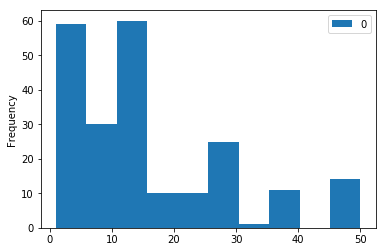

In [69]:
dems = [big_skus[s].weight if big_skus[s].weight > 0 else None for s in big_skus]
ax = pd.DataFrame(dems).plot.hist()
ax

In [ ]:
lambda_list = [(lambda x, params: x.get_demand(params), [0,24], 'demand'),
                (lambda x, params: x.get_weight(params), [], 'weight')]
for s in big_skus:
    print(s)
    sku = big_skus[s]
    for lmbd, params, name in lambda_list:
        print(lmbd(sku, params), name)